# Importance of FairShap on the tradeoff

$$
    \phi_i' = (1-\alpha)\mathbf{1}+\alpha \phi_i,\: \alpha \in [0,1]
$$

In [59]:
from utils.aif360_utils import stratified_aif360_split, compute_metrics, standarize_aif360_data
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

from utils.fair_metrics_raw import true_class_rate, false_class_rate, f1_p2, macro_f1_p2
from utils.norm import indenpendence_probability_norm

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics as sk_metrics 


import time
from tqdm import tqdm

In [60]:
from fairSV.fair_shapley_sklearn import get_SV_matrix_numba_memory, get_sv_arrays

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
def print_metrics_alpha(alpha):
        accs_A         = accs[alpha]
        eods_dif_A     = eods_dif[alpha]
        eods_abs_A     = eods_abs[alpha]
        eops_A         = eops[alpha]
        f1s_A          = f1s[alpha]
        macrof1s_A     = macrof1s[alpha]
        macrof1_inds_A = macrof1_inds[alpha]
        bas_A          = bas[alpha]
        times_A        = times[alpha]
        
        print(f"""
        #### {dataset_used}-{protected_attribute_used}:{dataset_orig.protected_attribute_names[0]}-{FAIR_TECHNIQUE}-{model_type}-RL:{RELABEL} ####
          * Acc : {np.mean(accs_A)*100:.2f}+-{np.std(accs_A):.3f}
          * BA  : {np.mean(bas_A)*100:.2f}+-{np.std(bas_A):.3f}
          * F1  : {np.mean(f1s_A):.3f}+-{np.std(f1s_A):.3f}
          * MF1 : {np.mean(macrof1s_A):.3f}+-{np.std(macrof1s_A):.3f}
          * MF1_inds : {np.mean(macrof1_inds_A):.3f}+-{np.std(macrof1_inds_A):.3f}


          * EOp_d  : {np.mean(eops_A):.3f}+-{np.std(eops_A):.3f}
          * EOp_a  : {np.mean(np.abs(eops_A)):.3f}+-{np.std(np.abs(eops_A)):.3f}

          * EOds_d : {np.mean(eods_dif_A):.3f}+-{np.std(eods_dif_A):.3f}
          * EOds_a : {np.mean(eods_abs_A):.3f}+-{np.std(eods_abs_A):.3f}

          * TIMES(SV): {np.mean(times_A):.3e}+-{np.std(times_A):.1e}
          * D (samples, feat): ({dataset_orig.features.shape[0]*0.7}, {dataset_orig.features.shape[1]})
          * T (samples, feat): ({dataset_orig.features.shape[0]*0.15}, {dataset_orig.features.shape[1]})
        """)
        
import scipy.stats as stats
def get_CI(m1, std1, c_level=.95, it=50):
    z = stats.norm.ppf((1+c_level)/2)
    standard_error = (std1 / (it ** 0.5))
    return z * standard_error

**EXPERIMENT PARAMETERS**

In [63]:
N_ITER = 100

RELABEL = True

SHOW_METRICS = False
SHOW_DETAIL  = False

In [64]:
N_ALPHAS = 11

In [65]:
dataset_used = 'german'
protected_attribute_used = 0 # 'sex' is 1, 0 other (german='age', compas and adult = 'race')
model_type = 'GBC'
FAIR_TECHNIQUE = ['sv_eop']

POTENTIAL_METHODS = ['GroupRW', 'sv_eop', 'sv_eod_diff', 'sv_eod_abs', 'sv_acc']

assert np.all([item in POTENTIAL_METHODS for item in FAIR_TECHNIQUE])

## DATA LOADING

In [66]:
if dataset_used == "adult":
    #dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
        
elif dataset_used == "german":
    #dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])

        
elif dataset_used == "compas":
    #dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

In [67]:
print(dataset_used, dataset_orig.protected_attribute_names)
print(("#### Training Dataset shape"))
print(dataset_orig.features.shape)
print(("#### Favorable and unfavorable labels"))
print('F:',dataset_orig.favorable_label, '- U:',dataset_orig.unfavorable_label)
print(dataset_orig.metadata['label_maps'])
print(("#### Protected attribute names and values"))
print(dataset_orig.protected_attribute_names, end='--> ')
print('P:',dataset_orig.privileged_protected_attributes, 
    '- U:',dataset_orig.unprivileged_protected_attributes)
print(dataset_orig.metadata['protected_attribute_maps'])
print(("#### Dataset feature names"))
print(dataset_orig.feature_names)

german ['age']
#### Training Dataset shape
(1000, 11)
#### Favorable and unfavorable labels
F: 1.0 - U: 2.0
[{1.0: 'Good Credit', 2.0: 'Bad Credit'}]
#### Protected attribute names and values
['age']--> P: [array([1.])] - U: [array([0.])]
[{1.0: 'Old', 0.0: 'Young'}]
#### Dataset feature names
['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [68]:
df = pd.DataFrame(np.hstack([dataset_orig.protected_attributes, dataset_orig.labels]),
                  columns=['A','Y'])
df ['Y'] = df['Y'].map(lambda x: dataset_orig.metadata['label_maps'][0][x])
df ['A'] = df['A'].map(lambda x: dataset_orig.metadata['protected_attribute_maps'][0][x])

In [69]:
df.value_counts()

A      Y          
Old    Good Credit    590
       Bad Credit     220
Young  Good Credit    110
       Bad Credit      80
dtype: int64

In [70]:
df['A'].value_counts(), df['A'].value_counts(normalize=True)

(Old      810
 Young    190
 Name: A, dtype: int64,
 Old      0.81
 Young    0.19
 Name: A, dtype: float64)

In [71]:
df['Y'].value_counts(), df['Y'].value_counts(normalize=True)

(Good Credit    700
 Bad Credit     300
 Name: Y, dtype: int64,
 Good Credit    0.7
 Bad Credit     0.3
 Name: Y, dtype: float64)

In [72]:
unpriv_group_idx= int(dataset_orig.unprivileged_protected_attributes[0][0])
unpriv_group_idx

0

## Training with different $\alpha$'s

In [73]:
np.random.seed(42)
seeds = np.random.randint(12345679,size=N_ITER)
seeds

array([ 6423388,  6550634, 10081351,  4304572,  2234489,  9958614,
        9524682,  7204212,  9628519,  4472471, 10526850,  4523669,
        7404852,  4981505,  1766891,  4521373,  6019877,  3344769,
        9180351,   103355,  1262752,  9784633,  5664789,  9695979,
        9305648,  5743066, 10642490,  6113790, 11919017,  4721339,
        9889550,  3275709,    84654,  5147581,  1954354, 10804790,
       11863283, 11041599,  8242680,  2428388,  8916786,  2663046,
       10975252,  5499720, 10959014,  6640913,  3416664,  3385659,
        3385357, 11184121,  1465689,    68148,  1825665,  2745683,
       11786331, 11392366,  4056518,  2669995,  4997895,  6397986,
        1870928,  4155299, 10946097, 10162023,  6249859,  2305413,
        3910197,  5558019,  5414709,   271836,  3584702, 10484113,
        7281369,  2299435,  8585377,  2658505,  1271741,  3769315,
        1046797,  3047262,  9973006, 10973639,   564685,  2879190,
        5596411,  9700344,  1007293,  4774183,  3366612,  8411

In [74]:
ALPHAS = np.linspace(0,1, N_ALPHAS)

In [75]:

datetime = time.strftime("%Y%m%d-%H%M%S")
accs = {}
eods_dif = {}
eods_abs = {}
eops = {}
f1s  = {}
macrof1s={}
bas  = {}
macrof1_inds ={}

times = {}

weights = {}

pred_exclude_lab = 0
pred_exclude_group_lab = 0


assert isinstance(FAIR_TECHNIQUE, list), f'FAIR_TECHNIIQUE MUST BE A LIST. Now: {FAIR_TECHNIQUE}'

np.random.seed(42)
seeds = np.random.randint(12345679,size=N_ITER)
seeds
for seed in tqdm(seeds):  

    for alpha in tqdm(ALPHAS, leave=False):

        if not alpha in accs:
            accs[alpha] = []
            eods_dif[alpha] = []
            eods_abs[alpha] = []
            eops[alpha] = []
            f1s[alpha] = []
            macrof1s[alpha] = []
            bas[alpha] = []
            macrof1_inds[alpha] = []
            weights[alpha] = []

            times[alpha] = []


        dataset_orig_train, dataset_orig_vt = stratified_aif360_split(dataset_orig, [0.7], shuffle=True, seed = seed)
        dataset_orig_valid, dataset_orig_test = stratified_aif360_split(dataset_orig_vt, [0.5], shuffle=True, seed = seed)

        #dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.5], shuffle=True, seed = seed)
        #dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True, seed = seed)

        if RELABEL:
            dataset_orig_train, privileged_groups, unprivileged_groups = standarize_aif360_data(dataset_orig_train)
            dataset_orig_valid, _, _ = standarize_aif360_data(dataset_orig_valid)
            dataset_orig_test, _, _ = standarize_aif360_data(dataset_orig_test)

        scale_orig = StandardScaler()
        X_train = scale_orig.fit_transform(dataset_orig_train.features)
        y_train = dataset_orig_train.labels.ravel()
        X_valid = scale_orig.transform(dataset_orig_valid.features)
        y_valid = dataset_orig_valid.labels.ravel()
        X_test = scale_orig.transform(dataset_orig_test.features)
        y_test = dataset_orig_test.labels.ravel()

        fav_lab     = dataset_orig_train.favorable_label
        unfav_lab   = dataset_orig_train.unfavorable_label
        priv_attr   = dataset_orig_train.privileged_protected_attributes[0][0]
        unpriv_attr = dataset_orig_train.unprivileged_protected_attributes[0][0]

        if any(item.startswith('sv') for item in FAIR_TECHNIQUE):
            sv_type = [item for item in FAIR_TECHNIQUE if item.startswith('sv')][0]
            assert sv_type in ['sv_acc', 'sv_eop', 'sv_eod_diff', 'sv_eod_abs']

            protected_attributes_dict = {'values':dataset_orig_valid.protected_attributes.ravel(),
                                            'privileged_protected_attribute': int(priv_attr),
                                            'unprivileged_protected_attribute': int(unpriv_attr),
                                            'favorable_label':int(fav_lab), 'unfavorable_label':int(unfav_lab)}

            sv_arrays = {}
            start = time.time()
            SV = get_SV_matrix_numba_memory(X_train, X_valid, y_train, y_valid, K=5)
            svs_acc, svs_eop, svs_eod_diff, svs_eod_abs = get_sv_arrays(SV, y_valid, protected_attributes_dict, 'all')
            end = time.time()
            times[alpha].append(end-start)
            sv_arrays["sv_acc"] = svs_acc
            sv_arrays["sv_eop"] = svs_eop
            sv_arrays["sv_eod_diff"] = svs_eod_diff
            sv_arrays["sv_eod_abs"] = svs_eod_abs

            weight = sv_arrays[sv_type].copy()
            #weight_acc = sv_arrays["sv_acc"].copy()
            dataset_orig_train.instance_weights = weight
            dataset_orig_train.instance_weights = (dataset_orig_train.instance_weights - dataset_orig_train.instance_weights.min())/(dataset_orig_train.instance_weights.max()-dataset_orig_train.instance_weights.min())
            dataset_orig_train.instance_weights *= (dataset_orig_train.labels.ravel().shape[0]/dataset_orig_train.instance_weights.sum())
        if 'GroupRW' in FAIR_TECHNIQUE:
            dataset_orig_train.instance_weights = indenpendence_probability_norm(dataset_orig_train.instance_weights,
                                                                                    labels=dataset_orig_train.labels.ravel(),
                                                                                    attrs=dataset_orig_train.protected_attributes.ravel(),
                                                                                    priv_attr=priv_attr, unpriv_attr=unpriv_attr,
                                                                                    fav_lab=fav_lab, unfav_lab=unfav_lab)


        if model_type == "GBC":
            model = GradientBoostingClassifier(random_state=seed)
        else:
            raise NotImplementedError()

        dataset_orig_train.instance_weights = (1-alpha)*1 + alpha*dataset_orig_train.instance_weights

        weights[alpha].append(dataset_orig_train.instance_weights.copy())


        model.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
        pos_ind = np.where(model.classes_ == dataset_orig_train.favorable_label)[0][0] # positive class index

        #! MODEL Predictions
        ## Train set
        train_pred= dataset_orig_train.copy(deepcopy=True)
        train_pred.labels = model.predict(X_train).reshape((-1, 1))
        train_pred.scores = model.predict_proba(X_train)[:, pos_ind].reshape(-1,1)
        ## Val
        val_pred = dataset_orig_valid.copy()
        val_pred.labels = model.predict(X_valid).reshape((-1, 1))
        val_pred.scores = model.predict_proba(X_valid)[:, pos_ind].reshape(-1,1)
        ## Test
        pred = dataset_orig_test.copy()
        pred.labels = model.predict(X_test).reshape((-1, 1))
        pred.scores = model.predict_proba(X_test)[:, pos_ind].reshape(-1,1)


        Acc = np.mean(pred.labels==dataset_orig_test.labels)

        f1 = f1_p2(dataset_orig_test.labels, pred.labels, class_label=fav_lab)
        #f1 = f1_p(dataset_orig_test.labels, pred.labels, label=fav_lab)
        f1 = 0 if np.isnan(f1) else f1
        macrof1 = macro_f1_p2(dataset_orig_test.labels, pred.labels)
        macrof1_ind = macro_f1_p2(dataset_orig_test.labels, pred.labels, individual_nan=True)
        macrof1 = 0 if np.isnan(macrof1) else macrof1

        #sk_f1 = metrics.f1_score(dataset_orig_test.labels, pred.labels)
        macro_sk = sk_metrics.f1_score(dataset_orig_test.labels, pred.labels, average='macro')

        TFavR = true_class_rate(dataset_orig_test.labels, pred.labels,fav_lab)
        TUnfavR = true_class_rate(dataset_orig_test.labels, pred.labels,unfav_lab)

        ba = (TFavR+TUnfavR)*0.5

        F_Unfav_R = false_class_rate(dataset_orig_test.labels, pred.labels,fav_lab)
        F_Fav_R = false_class_rate(dataset_orig_test.labels, pred.labels, unfav_lab)


        TFavR_Priv = true_class_rate(dataset_orig_test.labels, pred.labels,
                                        class_label = fav_lab, attribute = priv_attr,
                                        attributes = pred.protected_attributes)


        TFavR_Un = true_class_rate(dataset_orig_test.labels, pred.labels,
                                    fav_lab,
                                    pred.protected_attributes,
                                    unpriv_attr)


        TUnfavR_Priv = true_class_rate(dataset_orig_test.labels, pred.labels,
                                        unfav_lab,
                                        pred.protected_attributes,
                                        priv_attr)

        TUnfavR_Un = true_class_rate(dataset_orig_test.labels, pred.labels,
                                        unfav_lab,
                                        pred.protected_attributes,
                                        unpriv_attr)

        EOp = TFavR_Un-TFavR_Priv
        Diff_EOds = 0.5*( ((1-TUnfavR_Un)-(1-TUnfavR_Priv)) + (TFavR_Un-TFavR_Priv))
        Abs_EOds = 0.5*( np.abs((1-TUnfavR_Un)-(1-TUnfavR_Priv)) + np.abs(TFavR_Un-TFavR_Priv))


        accs[alpha].append(Acc)
        eods_dif[alpha].append(Diff_EOds)
        eods_abs[alpha].append(Abs_EOds)
        eops[alpha].append(EOp)
        f1s[alpha].append(f1)
        macrof1s[alpha].append(macrof1)
        macrof1_inds[alpha].append(macrof1_ind)
        bas[alpha].append(ba)  


        if SHOW_METRICS or SHOW_DETAIL:
            print()
            print(f'###########SEED:{seed}##############')

        if SHOW_METRICS:
            ndec = 4
            _=compute_metrics(dataset_orig_test, pred, unprivileged_groups, privileged_groups, disp = True)
            print(f"""-------------------------
            Acc          = {Acc:.{ndec}f}
            BA           = {ba:.{ndec}f}
            G-mean       = {np.sqrt(TFavR*TUnfavR):.{ndec}f}

            F1-score     = {f1:.{ndec}f}
            Macro-F1     = {macrof1:.{ndec}f}
            Macro-F1_ind = {macrof1_ind:.{ndec}f}

            SKMacro_f    = {macro_sk:.{ndec}f}

            T_Fav_R        = {TFavR:.{ndec}f} + F_Unfav_R = {F_Unfav_R:.{ndec}f} = {TFavR+F_Unfav_R}
            T_Unfav_R      = {TUnfavR:.{ndec}f} + F_Fav_R   = {F_Fav_R:.{ndec}f} = {TUnfavR+F_Fav_R}

            T_FavR_Priv   = {TFavR_Priv:.{ndec}f} --> F_UnfavR_Priv = 1-T_FavR_Priv   = {1-TFavR_Priv:.{ndec}f}
            T_FavR_Un     = {TFavR_Un:.{ndec}f} --> F_UnfavR_Un   = 1-T_FavR_Un     = {1-TFavR_Un:.{ndec}f}
            T_UnfavR_Priv = {TUnfavR_Priv:.{ndec}f} --> F_FavR_Priv   = 1-T_UnfavR_Priv = {1-TUnfavR_Priv:.{ndec}f}
            T_UnfavR_Un   = {TUnfavR_Un:.{ndec}f} --> F_FavR_Un     = 1-T_UnfavR_Un   = {1-TUnfavR_Un:.{ndec}f} 

            EOp       = {EOp:.{ndec}f} (Unpriv-Priv)
            Diff_EOds = {Diff_EOds:.{ndec}f} (Unpriv-Priv)
            Abs_EOds  = {Abs_EOds:.{ndec}f} abs(Unpriv-Priv)
            """)

            if np.abs(Diff_EOds)==Abs_EOds:
                print('\tCASE II Fairness - Higher FPR for one group and higer FNR for the other - SHIFT')
            else:
                print('\tCASE I Fairness - Higher FPR and FNR for the same group - COMPRESS')


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


In [76]:
print(pred_exclude_lab,pred_exclude_group_lab)

0 0


In [77]:
dataset_name = dataset_used.title()
attr_name = dataset_orig.protected_attribute_names[0].title()

In [78]:

dictionary = {'accs':accs,
                'eods_dif':eods_dif,
                'eods_abs':eods_abs,
                'eops':eops,
                'f1s': f1s,
                'macrof1s': macrof1s,
                'macrof1_inds': macrof1_inds,
                'bas': bas,
                'times': times
                }


In [79]:
print_metrics_alpha(1)


        #### german-0:age-['sv_eop']-GBC-RL:True ####
          * Acc : 68.14+-0.022
          * BA  : 50.12+-0.019
          * F1  : 0.807+-0.019
          * MF1 : 0.374+-0.172
          * MF1_inds : 0.444+-0.032


          * EOp_d  : -0.017+-0.089
          * EOp_a  : 0.063+-0.066

          * EOds_d : -0.006+-0.098
          * EOds_a : 0.068+-0.075

          * TIMES(SV): 4.575e-03+-7.6e-03
          * D (samples, feat): (700.0, 11)
          * T (samples, feat): (150.0, 11)
        


In [80]:
print_metrics_alpha(0)


        #### german-0:age-['sv_eop']-GBC-RL:True ####
          * Acc : 70.46+-0.017
          * BA  : 54.77+-0.021
          * F1  : 0.817+-0.012
          * MF1 : 0.527+-0.032
          * MF1_inds : 0.527+-0.032


          * EOp_d  : -0.236+-0.121
          * EOp_a  : 0.236+-0.121

          * EOds_d : -0.360+-0.113
          * EOds_a : 0.360+-0.113

          * TIMES(SV): 3.892e-03+-1.9e-03
          * D (samples, feat): (700.0, 11)
          * T (samples, feat): (150.0, 11)
        


## Plot results for different $\alpha$ values

In [81]:
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
d_names = {'None':'GBC','GroupRW': 'GroupRW',
           'sv_acc':'$\phi(Acc)$','sv_eop': '$\phi(EOp)$','sv_eod_diff': '$\phi(EOdds)$',
          }
def set_back_color(ax):
    # COLOR OF THE FRAME    
    framecolor = '#CED4D5'
    back_color = '#F2F8F9'#'#E5F2F4'#'#F1FAFA'
    tick_colors= '#5B5B5B'
    grid_color = '#CED4D5'
    
    ax = plt.gca()
    plt.grid(linestyle='--', color=grid_color)
    plt.tick_params(axis='both', colors=tick_colors)
    
    ax.set_facecolor(back_color)
    ax.spines['bottom'].set_color(framecolor)
    ax.spines['top'].set_color(framecolor)
    ax.spines['left'].set_color(framecolor)
    ax.spines['right'].set_color(framecolor)


def add_arrows(c1,c2):
    xleft, xright = plt.xlim()
    ybottom, yup  = plt.ylim()
    arrow_start = (xleft+(xright-xleft)*0.15,
                   ybottom+(yup-ybottom)*0.05)  # Bottom right corner with a bit pad

    xpoint = xleft +(xright-xleft)*0.15
    ypoint = ybottom + (yup-ybottom)/2
    arrow_end = (xpoint, ypoint)  # Middle of the plot
    
    plt.annotate(None,  # The text you want to display
                    xy=arrow_end,  # The position of the text (middle of the plot)
                    xytext=arrow_start,  # The position of the arrow (bottom right corner)
                    arrowprops={'arrowstyle': 'simple,head_length=2,head_width=2, tail_width=0.3',
                                'lw': 2, 'color': c1, 'alpha':.9 #3cba54,
                               },  # Arrow style and label
                    fontsize=12, color='red',  # Text style
                    ha='center', va='center',
                    )
    plt.text((arrow_start[0]+arrow_end[0])/2,
             (arrow_start[1]+arrow_end[1])/2,
             'Improvement', 
             fontsize=8,
             fontweight='bold',
             color='white',
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(facecolor=c1, alpha=.9, linewidth=0)
            )
    
    
    arrow_start = (xright-(xright-xleft)*0.15,
                   yup-(yup-ybottom)*0.27)  # Bottom right corner with a bit pad

    xpoint = arrow_start[0]
    ypoint = yup - (yup-ybottom)*0.7
    arrow_end = (xpoint, ypoint)  # Middle of the plot
    
    plt.annotate(None,  # The text you want to display
                    xy=arrow_end,  # The position of the text (middle of the plot)
                    xytext=arrow_start,  # The position of the arrow (bottom right corner)
                    arrowprops={'arrowstyle': 'simple,head_length=2,head_width=2, tail_width=0.3',
                                'lw': 2, 'color': c2, 'alpha':.9 #3cba54,
                               },  # Arrow style and label
                    fontsize=12, color='red',  # Text style
                    ha='center', va='center',
                    )
    plt.text((arrow_start[0]+arrow_end[0])/2,
             (arrow_start[1]+arrow_end[1])/2,
             'Improvement', 
             fontsize=8,
             fontweight='bold',
             color='white',
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(facecolor=c2, alpha=.9, linewidth=0)
            )


def _get_stats_df(metric_dict):
    df = pd.DataFrame(metric_dict)
    qual = df.agg([np.mean, np.std]).T
    qual = qual.rename_axis('alpha')
    qual['ci']  = get_CI(qual['mean'], qual['std'], it=50)
    qual['mean'] = qual['mean'].abs()
    return qual
    
def plot_scatter_metrics(metrics_arrays, metrics_names, size=100, return_fig=False, leg='inside'):
    assert len(metrics_arrays) == len(metrics_names), '# of arrays and names does not match.'
    sns.set_context("paper", font_scale=1.5)
    
    f = plt.figure(figsize=(7,4)) if leg=='outside' else plt.figure(figsize=(5,4))
    
    color_lines = ['darkgreen','darkcyan','chocolate','maroon']
    
    colormap_name = 'coolwarm_r'
    num_colors = len(metrics_arrays[0])
    cmap_a = cm.get_cmap(colormap_name, num_colors)
    values = np.linspace(0, 1, num_colors)
    color_alphas = cmap_a(values)
    
    for i, m in enumerate(metrics_arrays):
        qual = _get_stats_df(m)
        
        for j, alpha in enumerate(qual.index):
            plt.scatter(alpha, qual.loc[alpha]['mean'], zorder=99,s=size,
                        color=color_alphas[j], edgecolor=color_lines[i], linewidth=2)
            plt.errorbar(alpha, qual.loc[alpha]['mean'], yerr=qual.loc[alpha]['ci'],
                         fmt='none', capsize=5,zorder=0, color=color_alphas[j], alpha=0.6)
            
        
        plt.plot(qual.index, qual['mean'], label=metrics_names[i],zorder=1, color=color_lines[i], linewidth=2)
    
    plt.xlabel(r'$\alpha$')
    if leg=='inside':
        plt.legend(loc='best', #bbox_to_anchor=(1, 1),
                   fancybox=True, framealpha=0.9, markerscale=1.1)
    elif leg=='outside':
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1),
                   fancybox=True, framealpha=0.9, markerscale=1.3)
    
    
    plt.title(f'{dataset_used.upper()} ({dataset_orig.protected_attribute_names[0]})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    
    framecolor = '#CED4D5'
    back_color = '#F7FBFB'#'#F2F8F9'
    ax = plt.gca()
    ax.set_facecolor(back_color)
    ax.spines['bottom'].set_color(framecolor)
    ax.spines['top'].set_color(framecolor)
    ax.spines['left'].set_color(framecolor)
    ax.spines['right'].set_color(framecolor)
    
    plt.tight_layout()
    plt.show()
    if return_fig:
        return f
    
def plot_biaxis_scatter(metrics_arrays, metrics_names, size=100, return_fig=False):
    assert len(metrics_arrays) == 2, '# of arrays should be 2. If more, please use `plot_scatter_metrics`.'
    assert len(metrics_arrays) == len(metrics_names), '# of arrays and names does not match.'
    sns.set_context("paper", font_scale=1.5)
    
    color_lines = ['darkgreen','maroon']
    colormap_name = 'coolwarm_r'
    
    # Define the number of colors you want
    num_colors = len(metrics_arrays[0])
    cmap_d = cm.get_cmap(colormap_name, num_colors)
    values = np.linspace(0, 1, num_colors)
    color_alphas = cmap_d(values)


    fig, ax1 = plt.subplots(figsize=(6,4))
    qual = _get_stats_df(metrics_arrays[0])

    #ax1.set_xlabel(f'$\\alpha$\n$\\alpha=0=$GBC   -   $\\alpha=1=${d_names[FAIR_TECHNIQUE[0]]}')
    ax1.set_xlabel(f'$\\alpha$')
    ax1.set_ylabel(metrics_names[0], color=color_lines[0])
    ax1.tick_params(axis='y', labelcolor=color_lines[0])
    for i, alpha in enumerate(qual.index):
            ax1.scatter(alpha, qual.loc[alpha]['mean'], s=size,
                        color=color_alphas[i], zorder=99, edgecolor=color_lines[0], linewidth=2)
            ax1.errorbar(alpha, qual.loc[alpha]['mean'], yerr=qual.loc[alpha]['ci'], color=color_alphas[i],
                         fmt='none', capsize=5,zorder=0, alpha=0.5)
    lns1 = ax1.plot(qual.index, qual['mean'], label=metrics_names[0], linewidth=2,
                    zorder=1,color=color_lines[0], alpha=0.7)
    
    
    ## SECOND AXIS
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    qual = _get_stats_df(metrics_arrays[1])

    ax2.set_ylabel(metrics_names[1], color=color_lines[1])
    ax2.tick_params(axis='y', labelcolor=color_lines[1])
    for i, alpha in enumerate(qual.index):
            ax2.scatter(alpha, qual.loc[alpha]['mean'],s=size,
                        color=color_alphas[i], zorder=99, edgecolor=color_lines[1], linewidth=2)
            ax2.errorbar(alpha, qual.loc[alpha]['mean'], yerr=qual.loc[alpha]['ci'], color=color_alphas[i],
                         fmt='none', capsize=5,zorder=0, alpha=0.5)
            
    lns2 = ax2.plot(qual.index, qual['mean'], label=metrics_names[1], linewidth=2,
                    zorder=1,color=color_lines[1], alpha=0.7)
    
    
    leg = lns1 + lns2
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc='best')
    
    framecolor = '#CED4D5'
    back_color = '#F7FBFB'#'#F2F8F9'
    ax1.set_facecolor(back_color)
    ax2.spines['bottom'].set_color(framecolor)
    ax2.spines['top'].set_color(framecolor)
    ax2.spines['left'].set_color(framecolor)
    ax2.spines['right'].set_color(framecolor)
    
    add_arrows(color_lines[0], color_lines[1])
    
    plt.title(f'{dataset_used.upper()} ({dataset_orig.protected_attribute_names[0]})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    if return_fig:
        return fig


def plot_pareto_metrics(metrics_arrays, metrics_names, return_fig=False):
    '''
    Plots pareto fron for the 2 arrays. One scatter for each alpha value.
    In case that different values of alpha are stored on the different dictionaries a inner join is done
    (plot alphas that are in both arrays).
    '''
    assert len(metrics_arrays) == 2, '# of arrays should be 2. If more, please use `plot_scatter_metrics`.'
    assert len(metrics_arrays) == len(metrics_names), '# of arrays and names does not match.'
    sns.set_context("paper", font_scale=1.5)
    
    f = plt.figure(figsize=(6,4))  
    
    
    qualy = _get_stats_df(metrics_arrays[0])
    qualx = _get_stats_df(metrics_arrays[1])
    
    colormap_name = 'coolwarm_r'
    num_colors = len(metrics_arrays[0])
    cmap_a = cm.get_cmap(colormap_name, num_colors)
    values = np.linspace(0, 1, num_colors)
    color_alphas = cmap_a(values)
    
    for i, alpha in enumerate(metrics_arrays[0].keys()):
        
        mx = qualx.loc[alpha]['mean']
        my = qualy.loc[alpha]['mean']
        stdx = qualx.loc[alpha]['ci']
        stdy = qualy.loc[alpha]['ci']
        plt.scatter(mx, my, s=200, zorder=10, color = color_alphas[i],
                   edgecolor='grey', alpha=1)
        plt.errorbar(mx, my, xerr=stdx, yerr=stdy,
                     elinewidth=1, ecolor=color_alphas[i],
                     fmt=' ', alpha=0.6, capsize=2)
    
    plt.plot(qualx['mean'], qualy['mean'], color='darkgrey')
    plt.xlabel(metrics_names[1])
    plt.ylabel(metrics_names[0])
    
    
    
    framecolor = '#CED4D5'
    back_color = '#F7FBFB'#'#F2F8F9'
    ax = plt.gca()
    ax.set_facecolor(back_color)
    ax.spines['bottom'].set_color(framecolor)
    ax.spines['top'].set_color(framecolor)
    ax.spines['left'].set_color(framecolor)
    ax.spines['right'].set_color(framecolor)
    
    plt.title(f'{dataset_used.upper()} ({dataset_orig.protected_attribute_names[0]})')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    sm = ScalarMappable(cmap=cmap_a)
    cbar = plt.colorbar(sm, label='$\\alpha$')
    label = cbar.ax.yaxis.label
    label.set_rotation(0)  # Rotate the label by 90 degrees
    label.set_verticalalignment('center')
    
    plt.tight_layout()
    plt.show()
    if return_fig:
        return f
    


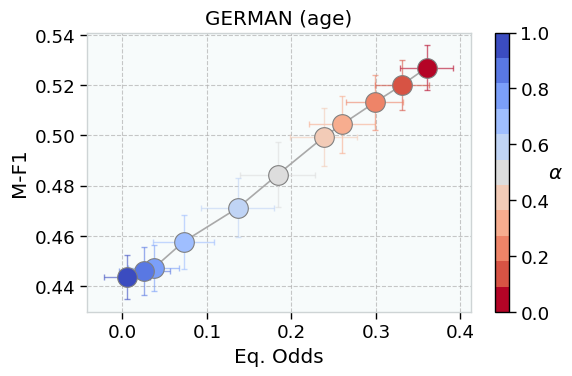

In [83]:
f  = plot_pareto_metrics([macrof1_inds, eods_dif],['M-F1', 'Eq. Odds'], return_fig = True)


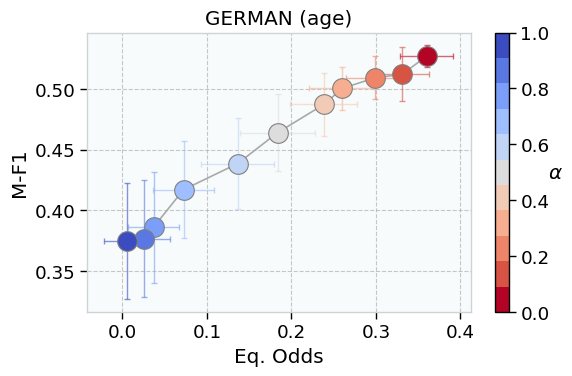

In [84]:
f  = plot_pareto_metrics([macrof1s, eods_dif],['M-F1', 'Eq. Odds'], return_fig = True)

All

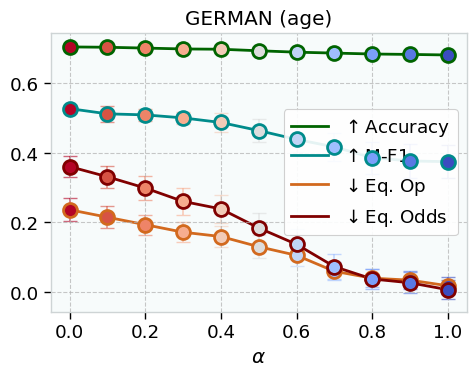

In [85]:
f = plot_scatter_metrics([accs, macrof1s, eops, eods_dif],
                         ['$\\uparrow$Accuracy', '$\\uparrow$M-F1',
                          '$\\downarrow$Eq. Op', '$\\downarrow$Eq. Odds'],
                         return_fig = True,
                         leg='inside')


Pair

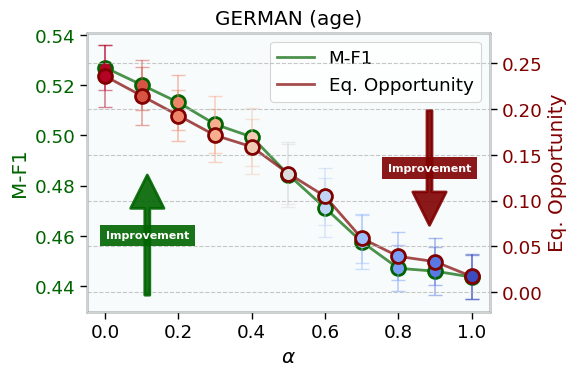

In [86]:
f = plot_biaxis_scatter([macrof1_inds, eops],['M-F1', 'Eq. Opportunity'], return_fig = True)


## Data Analysis - Plot distribution of weights according to alpha

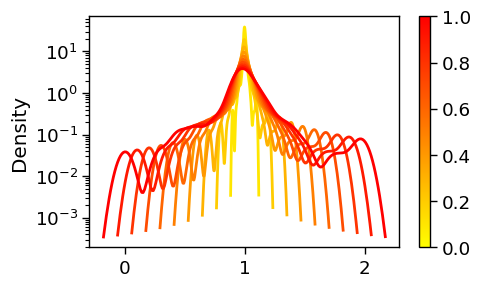

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
#plot the distribution of weights for every alpha
plt.figure(figsize=(5, 3))
#create colorbar for alpha (it goes from o to 1)
cmap = plt.get_cmap('autumn_r')
colors = [cmap(i) for i in np.linspace(0, 1, len(weights))]
for ix, a in enumerate(weights):
    sns.kdeplot(weights[a][0], label=a, color=colors[ix], linewidth=2)

#show colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm)
plt.yscale('log')
#plt.ylim(0, 40)
plt.show()

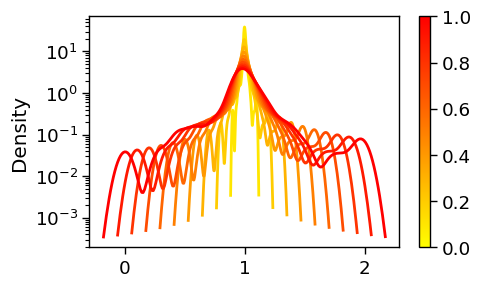

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
#plot the distribution of weights for every alpha
plt.figure(figsize=(5, 3))
#create colorbar for alpha (it goes from o to 1)
cmap = plt.get_cmap('autumn_r')
colors = [cmap(i) for i in np.linspace(0, 1, len(weights))]
for ix, a in enumerate(weights):
    sns.kdeplot(weights[a][0], label=a, color=colors[ix], linewidth=2)

#show colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm)
plt.yscale('log')
#plt.ylim(0, 40)
plt.show()

In [89]:
Y  =dataset_orig_train.labels.ravel()
A = dataset_orig_train.protected_attributes.ravel()

In [90]:
weights[1][0].shape, Y.shape, A.shape

((700,), (700,), (700,))

In [91]:
def show_weights(weights, alpha, fill=False):#same as before but with sns kdeplot
    f, ax = plt.subplots(1,3,figsize=(16, 3.5))

    left_lim = 0.5#weights[max(weights.keys())][0].min()-0.5
    right_lim = 1.5#weights[max(weights.keys())][0].max()+0.5

    sns.kdeplot(weights[alpha][-1][A==1], color='blue', label='Priv', ax=ax[0])
    sns.kdeplot(weights[alpha][-1][A==0], color='orange', label='Unpriv', ax=ax[0])
    ax[0].legend(loc='best', fancybox=True, framealpha=0.9, markerscale=1.1, title='Group')
    ax[0].set_xlim(left_lim, right_lim)

    sns.kdeplot(weights[alpha][-1][Y==1], color='darkgreen', label='Fav', ax=ax[1])
    sns.kdeplot(weights[alpha][-1][Y==0], color='red', label='Unfav', ax=ax[1])
    ax[1].legend(loc='best', fancybox=True, framealpha=0.9, markerscale=1.1, title='Label')
    ax[1].set_xlim(left_lim, right_lim)

    sns.kdeplot(weights[alpha][-1][(Y==1) & (A==1)], color='darkgreen', label='Fav-Priv', ax=ax[2], fill=fill)
    sns.kdeplot(weights[alpha][-1][(Y==0) & (A==1)], color='blue', label='Unfav-Priv', ax=ax[2], fill=fill)
    sns.kdeplot(weights[alpha][-1][(Y==1) & (A==0)], color='orange', label='Fav-Unpriv', ax=ax[2], fill=fill)
    sns.kdeplot(weights[alpha][-1][(Y==0) & (A==0)], color='red', label='Unfav-Unpriv', ax=ax[2], fill=fill)
    ax[2].set_xlim(left_lim, right_lim)
    #ax[2].set_yscale('log')
    ax[2].legend(loc='best', fancybox=True, framealpha=0.9, markerscale=1.1, title='Label-Group')


    #set big title
    plt.suptitle(f'Weights distribution for $\\alpha={alpha}$ ($\phi(EOp)$)')
    plt.tight_layout()
    plt.show()

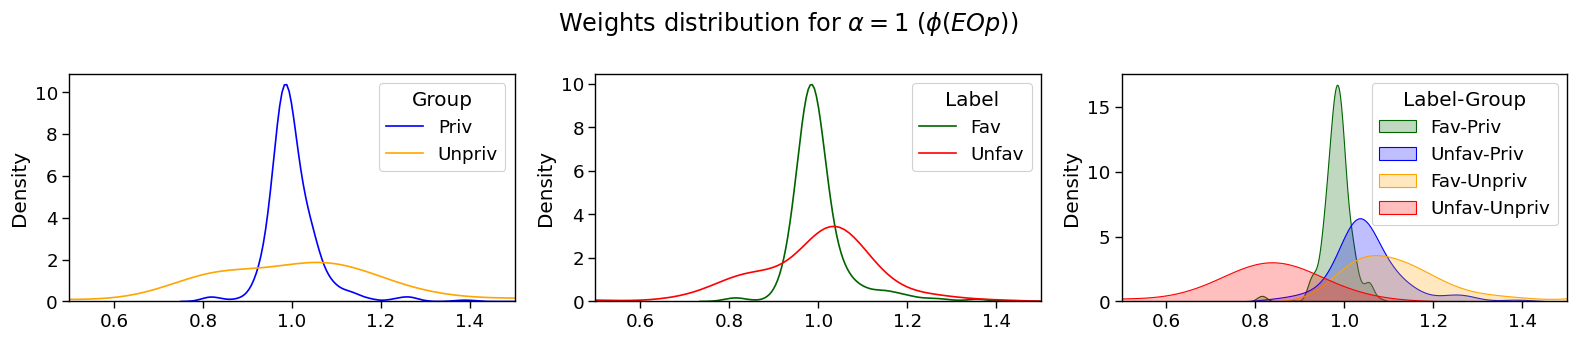

In [92]:
show_weights(weights, 1, fill=True)

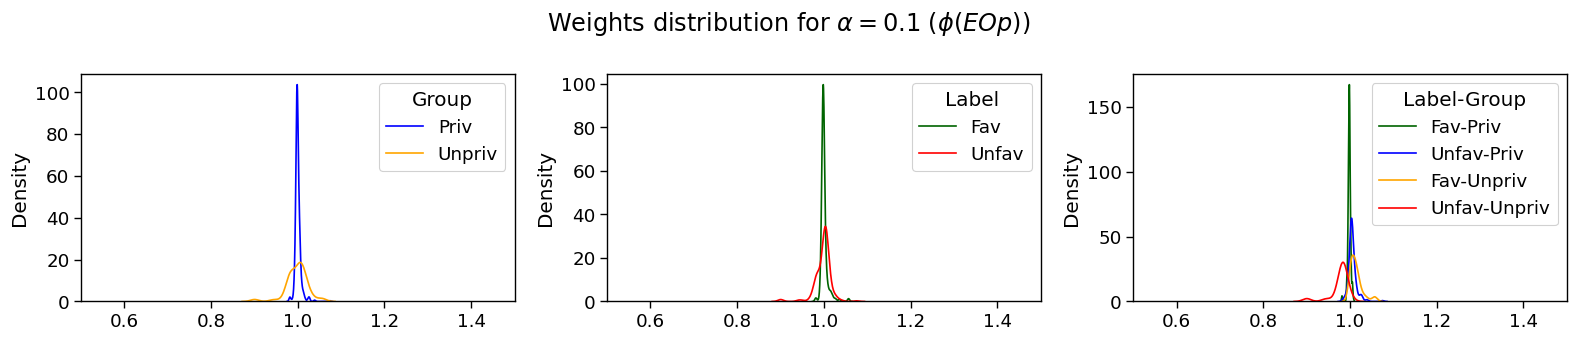

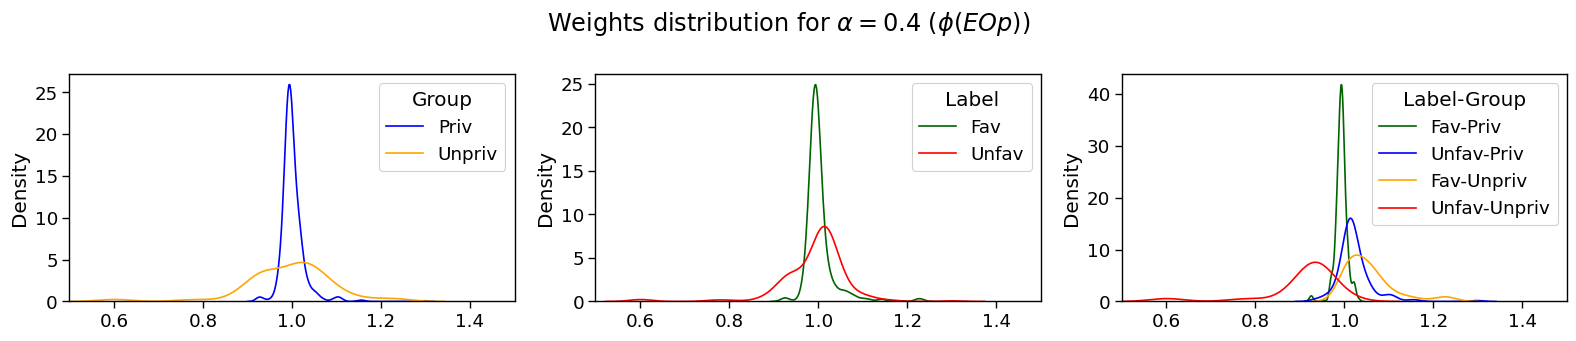

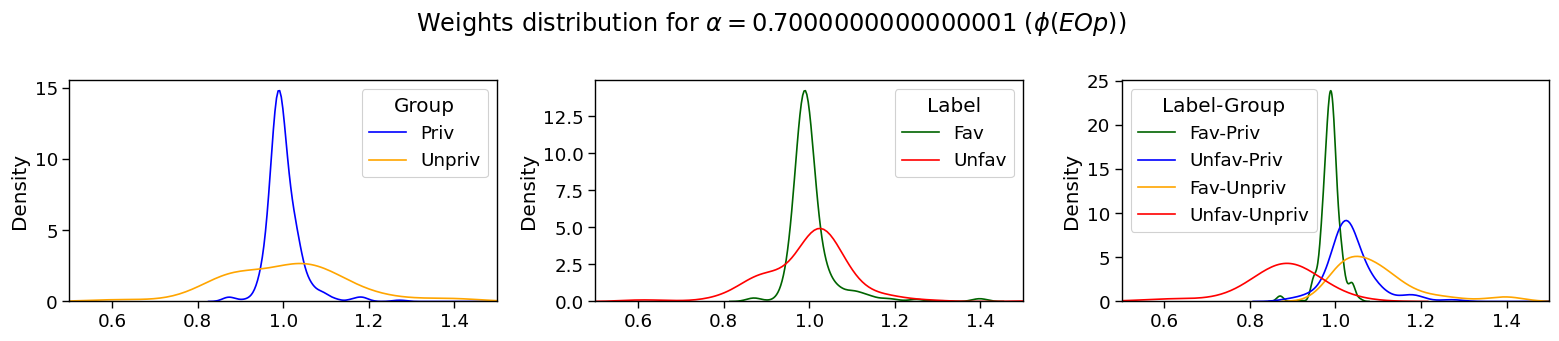

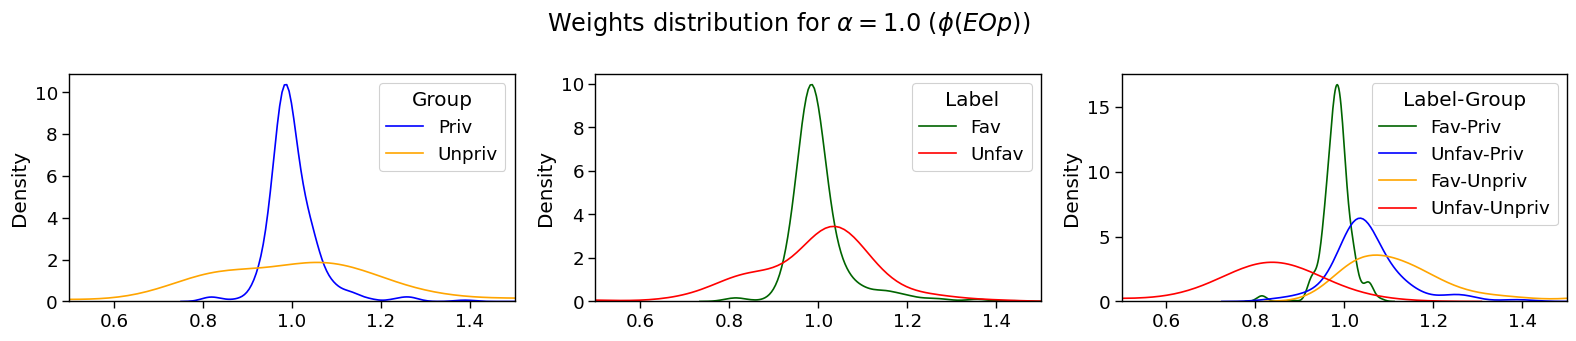

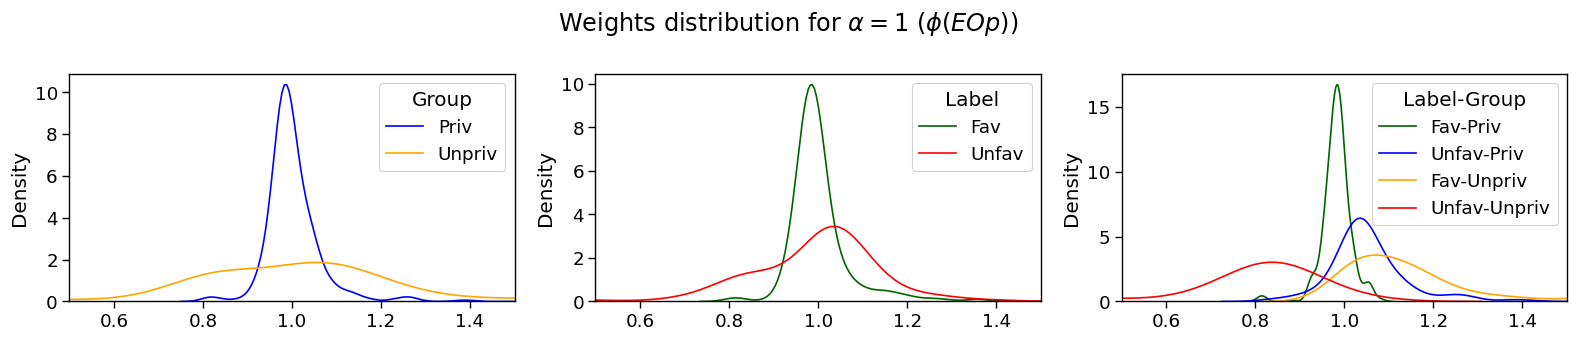

In [93]:
for aa in list(weights.keys())[1::3]:
    show_weights(weights, aa)
show_weights(weights, 1)

In [94]:
import matplotlib as mpl
import copy

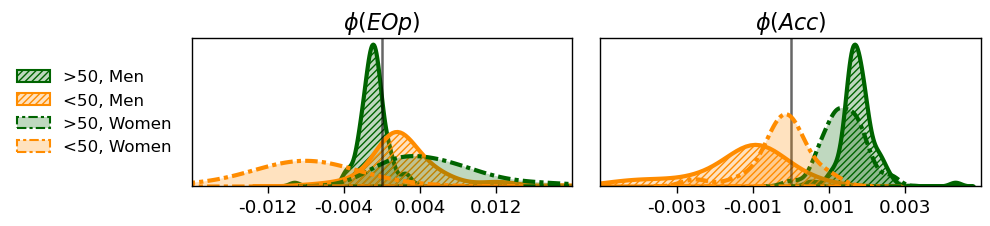

In [102]:

f, ax = plt.subplots(1,2,figsize=(10, 2.5))

linestyle = (0, (3, 1, 1, 1))


sv_type = 'sv_eop'
left_lim = -0.02#sv_arrays[sv_type].min()-0.005
right_lim = 0.02#sv_arrays[sv_type].max()+0.005
abslim = max(np.abs(left_lim), np.abs(right_lim))

sns.kdeplot(sv_arrays[sv_type][(Y==1) & (A==1)], color='darkgreen', hatch='/////', label='>50, Men', ax=ax[0], fill=True, linewidth=3)
sns.kdeplot(sv_arrays[sv_type][(Y==0) & (A==1)], color='darkorange', hatch='/////', label='<50, Men', ax=ax[0], fill=True, linewidth=3)
sns.kdeplot(sv_arrays[sv_type][(Y==1) & (A==0)], color='darkgreen',linestyle=linestyle, label='>50, Women', ax=ax[0], fill=True, linewidth=3)
sns.kdeplot(sv_arrays[sv_type][(Y==0) & (A==0)], color='darkorange',linestyle=linestyle, label='<50, Women', ax=ax[0], fill=True, linewidth=3)
ax[0].set_xlim(-abslim, abslim)
#ax[0].legend(loc='best', fancybox=True, framealpha=0.9, markerscale=1.1, title='Label-Group')
ax[0].axvline(0, color='black', linewidth=1.8,  linestyle='-', alpha=.6)
ax[0].set_title('$\phi(EOp)$', fontsize=16)

#remove yticks and labels
ax[0].set_yticks([])
ax[0].set_ylabel('')
ax[0].set_yticklabels([])

#set 6 xtiks evenly space, from left_lim to right lim
tiks_num=np.linspace(-abslim, abslim, 6)[1:-1]
ax[0].set_xticks(tiks_num)
#set the labels as the absolute values of the ticks
ax[0].set_xticklabels([f'{i}' for i in tiks_num])



left_lim = 0.005#sv_arrays['sv_acc'].min()
right_lim = 0.005#sv_arrays['sv_acc'].max()
abslim = max(np.abs(left_lim), np.abs(right_lim))


sns.kdeplot(sv_arrays['sv_acc'][(Y==1) & (A==1)], color='darkgreen', hatch='/////', label='>50, Men', ax=ax[1], fill=True, linewidth=3)
sns.kdeplot(sv_arrays['sv_acc'][(Y==0) & (A==1)], color='darkorange', hatch='/////', label='<50, Men', ax=ax[1], fill=True, linewidth=3)
sns.kdeplot(sv_arrays['sv_acc'][(Y==1) & (A==0)], color='darkgreen',linestyle=linestyle, label='>50, Women', ax=ax[1], fill=True, linewidth=3,zorder=10)
sns.kdeplot(sv_arrays['sv_acc'][(Y==0) & (A==0)], color='darkorange',linestyle=linestyle, label='<50, Women', ax=ax[1], fill=True, linewidth=3,zorder=10)
ax[1].set_xlim(-abslim, abslim)
ax[1].axvline(0, color='black', linewidth=1.8,  linestyle='-', alpha=.6)
#ax[2].set_yscale('log')
#ax[0].legend(loc='best', fancybox=True, framealpha=0.9, markerscale=1.1, title='Label-Group')
ax[1].set_title('$\phi(Acc)$', fontsize=16)

ax[1].set_yticks([])
ax[1].set_ylabel('')
ax[1].set_yticklabels([])

#set 6 xtiks evenly space, from left_lim to right lim
tiks_num=np.linspace(-abslim, abslim, 6)[1:-1]
ax[1].set_xticks(tiks_num)
#set the labels as the absolute values of the ticks
ax[1].set_xticklabels([f'{i}' for i in tiks_num])


handles, labels = ax[0].get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles]
# set the linewidths to the copies
[ha.set_linewidth(1.5) for ha in handles]
# put the copies into the legend
leg = ax[0].legend(loc = 'center left', bbox_to_anchor=(-.5,.5), handles=handles, labels=labels, fontsize=12,
                   fancybox=True, framealpha=0, markerscale=1.1)

plt.tight_layout()
plt.show()